# Exercise 12

Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should
probably reduce the dataset's dimensionality (e.g. use PCA, preserving 99% of variance). Use the model
to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will
need to use its `inverse_transform()` method). Try to modify some images (e.g. rotate, flip, darken)
and see if the model can detect the anomalies (i.e. compare the output of the `score_samples()` method
for normal images and for anomalies).

### Imports

In [3]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from numpy.typing import NDArray
import numpy as np
from sklearn.mixture import GaussianMixture
from typing import Any, Callable
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [4]:
olivetti = fetch_olivetti_faces()

## Step 1. Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(olivetti.data, olivetti.target, stratify=olivetti.target, test_size=0.2, random_state=42)

## Step 2. Reduce dataset's dimensionality with PCA

In [6]:
def determine_optimal_pca_components(
    X_train: NDArray[np.floating], variance_threshold: float = 0.95
) -> int:
    """
    Calculate the minimum number of principal components needed to retain a specified percentage of the variance.

    Args:
        X_train: 2D array-like, shape (n_samples, n_features), the training data.
        variance_threshold: Float between 0 and 1, the target fraction of variance to retain (default: 0.95).

    Returns:
        The minimum number of PCA components required to preserve at least the desired variance.
    """
    pca = PCA().fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= variance_threshold) + 1
    print(
        f"Optimal number of PCA components to keept at least variance {variance_threshold:.0%} is {d}"
    )
    return d

In [7]:
n_components = determine_optimal_pca_components(X_train, 0.99)
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)

Optimal number of PCA components to keept at least variance 99% is 222


## Step 3. Select the number of cluster using aic() or `BayesianGaussianMixture`


In [8]:
def compute_aic(k: int, X: NDArray[Any]) -> float:
    gm = GaussianMixture(n_components=k, n_init=10, random_state=42)
    gm.fit(X)
    return gm.aic(X)

In [9]:
def find_optimal_clusters(
    k_values: np.ndarray,
    X: NDArray[Any],
    score_func: Callable[[int, NDArray[Any]], float],
    n_jobs=-1,
) -> tuple[np.ndarray, list[float]]:
    """
    Evaluates a given scoring function (in parallel) across multiple values of k for clustering.

    Args:
        k_values: Array of candidate 'k' (number of clusters/components) values to evaluate.
        X: Data to cluster (2D array: samples x features).
        score_func: Function that takes (k, X) and returns a float score (e.g., silhouette or AIC).
        n_jobs: Number of parallel jobs (-1 uses all available processors).

    Returns:
        Tuple of (k_values, scores) where scores is a list of floats from score_func for each k.
    """
    scores = Parallel(n_jobs=n_jobs)(delayed(score_func)(k, X) for k in k_values)
    return k_values, scores

In [10]:
(k_candidates, k_scores) = find_optimal_clusters(
    np.arange(30, 60, 3), X_train_reduced, compute_aic
)
optimal_k = k_candidates[np.argmax(k_scores)]
# establishes as 57
print(f"Best k for max score is {optimal_k}")

Best k for max score is 57


## Step 4. Train a Gaussian mixture on the reduced dataset

In [11]:
gm = GaussianMixture(n_components=optimal_k, n_init=10, random_state=42)
gm.fit(X_train_reduced)
print(f"GM converged {gm.converged_} in {gm.n_iter_} iterations")

GM converged True in 2 iterations


## Step 5. Sample a few new faces and visualize them

In [12]:
X_new_reduced, y_new_reduced = gm.sample(4)

In [13]:
X_new = pca.inverse_transform(X_new_reduced)
new_images = X_new.reshape(-1, 64, 64)

In [14]:
def plot_faces(faces, labels, n_cols=5, display_handler=None):
    """
    Plot faces in a grid with flexible display handling

    Args:
        faces: Array of face images (shape: n_samples X 4096)
        labels: List of labels for each face
        n_cols: Number of columns iin grid
        display_handler: Function that handles display/saving
                         Signature: handler(fig) -> None
    """
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    fig = plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))

    for index, (face, label) in enumerate(zip(faces, labels)):
        ax = fig.add_subplot(n_rows, n_cols, index + 1)
        ax.imshow(face, cmap="gray")
        ax.axis("off")
        ax.set_title(str(label), fontsize=9)

    plt.tight_layout()

    if display_handler:
        display_handler(fig)
    else:
        plt.show()
    plt.close(fig)

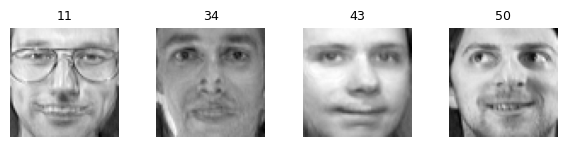

In [16]:
plot_faces(
    X_new,
    y_new_reduced,
    n_cols=4
)

## Step 6. Modify some other images and see if the model can detect anomalies